In [1]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [2]:
from datasets import DatasetIN12, IN12_MEAN, IN12_STD
import numpy as np
import torchvision.transforms.v2 as v2
import torch.utils.data as torchdata
from torch.utils.data import DataLoader

### Set hyperparameters

In [3]:
learning_rate = 0.001
epochs = 50
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/final/IN12_blur_final"

os.makedirs(output_dir, exist_ok=True)

### Define transforms

In [4]:
rng = np.random.default_rng(seed=5)

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=IN12_MEAN, std=IN12_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=IN12_MEAN, std=IN12_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load ImageNet12 dataset

In [5]:
train_dataset = DatasetIN12(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = DatasetIN12(train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = DatasetIN12(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 18000
Val set size: 1200
Test set size: 1200


### Create ResNet18 model

In [10]:
import torch
import torch.nn as nn
from model import ResNet18Sup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18Sup(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=(epochs - 2) * steps)
combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer,
                                                            schedulers=[warmup_scheduler, decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [7]:
!pip install kornia

In [11]:
from utils import add_blur_with

# Initialize metrics for ploting
train_losses, train_correct = [], []
val_losses, val_correct = [], []
logs = []

model.eval()
train_loss, train_corr, total_train = 0, 0, 0

with torch.no_grad():
    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        y_pred = model(images)
        loss = criterion(y_pred, labels)

        train_loss += loss.item() * images.size(0)
        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == labels).sum().item()
        total_train += labels.size(0)

avg_train_loss = train_loss / total_train
train_accuracy = (train_corr / total_train) * 100

val_loss, val_corr, total_val = 0, 0, 0

with torch.no_grad():
    for (indices, actual_indices), images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        y_val_pred = model(images)
        loss = criterion(y_val_pred, labels)

        val_loss += loss.item() * images.size(0)
        predicted = torch.max(y_val_pred, 1)[1]
        val_corr += (predicted == labels).sum().item()
        total_val += labels.size(0)

avg_val_loss = val_loss / total_val
val_accuracy = (val_corr / total_val) * 100

# Save results for plotting
train_losses.append(avg_train_loss)
train_correct.append(train_accuracy)
val_losses.append(avg_val_loss)
val_correct.append(val_accuracy)

# Logging the results of the epoch
log_entry = (f"Epoch 0/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
print(log_entry)
logs.append(log_entry)

Epoch 0/50, Train Loss: 2.4902, Train Acc: 6.59, Val Loss: 2.4879, Val Acc: 7.52%


### Training loop

In [12]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    model.train()
    for idx, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 10:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch >= 10 and epoch < 20:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch >= 20 and epoch < 30:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch >= 30 and epoch < 40:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        elif epoch >= 40:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        combined_scheduler.step()

    # Evaluate on training set
    model.eval()
    train_loss, train_corr, total_train = 0, 0, 0

    with torch.no_grad():
        for _, images, labels in train_loader:
            if epoch < 10:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch >= 10 and epoch < 20:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch >= 20 and epoch < 30:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch >= 30 and epoch < 40:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            elif epoch >= 40:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            images, labels = images.to(device), labels.to(device)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            train_loss += loss.item() * images.size(0)
            predicted = torch.max(y_pred.data, 1)[1]
            train_corr += (predicted == labels).sum().item()
            total_train += labels.size(0)

    avg_train_loss = train_loss / total_train
    train_accuracy = (train_corr / total_train) * 100

    ###################### Evaluate model ######################
    val_loss, val_corr, total_val = 0, 0, 0

    with torch.no_grad():
        for _, images, labels in val_loader:

            # Should I add blur to these images too???
            images, labels = images.to(device), labels.to(device)

            y_val_pred = model(images)
            loss = criterion(y_val_pred, labels)

            val_loss += loss.item() * images.size(0)
            predicted = torch.max(y_val_pred, 1)[1]
            val_corr += (predicted == labels).sum().item()
            total_val += labels.size(0)


    avg_val_loss = val_loss / total_val
    val_accuracy = (val_corr / total_val) * 100

    # Save results of current epoch
    train_losses.append(avg_train_loss)
    train_correct.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_correct.append(val_accuracy)

    # Add epoch results to log file
    log_entry = (f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    print(log_entry)
    logs.append(log_entry)

    # Save checkpoint every 10 epochs
    if (epoch+1) % 10 == 0:
        checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
        }
        torch.save(checkpoint, checkpoint_path)

Epoch 1/50, Train Loss: 2.5237, Train Acc: 21.67, Val Loss: 5.6329, Val Acc: 12.89%
Epoch 2/50, Train Loss: 2.5445, Train Acc: 23.73, Val Loss: 4.1616, Val Acc: 16.70%
Epoch 3/50, Train Loss: 2.1544, Train Acc: 27.64, Val Loss: 2.9833, Val Acc: 19.34%
Epoch 4/50, Train Loss: 1.9358, Train Acc: 33.87, Val Loss: 2.7130, Val Acc: 22.36%
Epoch 5/50, Train Loss: 1.8540, Train Acc: 37.93, Val Loss: 2.7339, Val Acc: 28.22%
Epoch 6/50, Train Loss: 1.8083, Train Acc: 37.93, Val Loss: 2.8958, Val Acc: 21.29%
Epoch 7/50, Train Loss: 1.8307, Train Acc: 38.38, Val Loss: 3.0288, Val Acc: 21.00%
Epoch 8/50, Train Loss: 1.8271, Train Acc: 40.75, Val Loss: 4.0674, Val Acc: 20.12%
Epoch 9/50, Train Loss: 1.4754, Train Acc: 49.06, Val Loss: 2.6903, Val Acc: 25.39%
Epoch 10/50, Train Loss: 1.6144, Train Acc: 44.91, Val Loss: 3.4413, Val Acc: 21.48%
Epoch 11/50, Train Loss: 1.3283, Train Acc: 54.32, Val Loss: 1.4415, Val Acc: 50.98%
Epoch 12/50, Train Loss: 1.4642, Train Acc: 50.04, Val Loss: 1.4885, Val A

## Test model after training

In [13]:
model.eval()
test_loss, test_correct, total_test = 0, 0, 0

with torch.no_grad():
    for _, images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        predicted = torch.max(outputs, 1)[1]
        test_correct += (predicted == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = test_loss / total_test
test_accuracy = (test_correct / total_test) * 100

# Add test results to log file
log_entry = (f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print(log_entry)
logs.append(log_entry)

Test Loss: 0.6213, Test Accuracy: 80.37%


### Save logs to a txt file

In [14]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

metrics = {
    'train_losses': train_losses,
    'train_correct': train_correct,
    'val_losses': val_losses,
    'val_correct': val_correct
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(metrics, metrics_file)

### Plot loss and accuracy

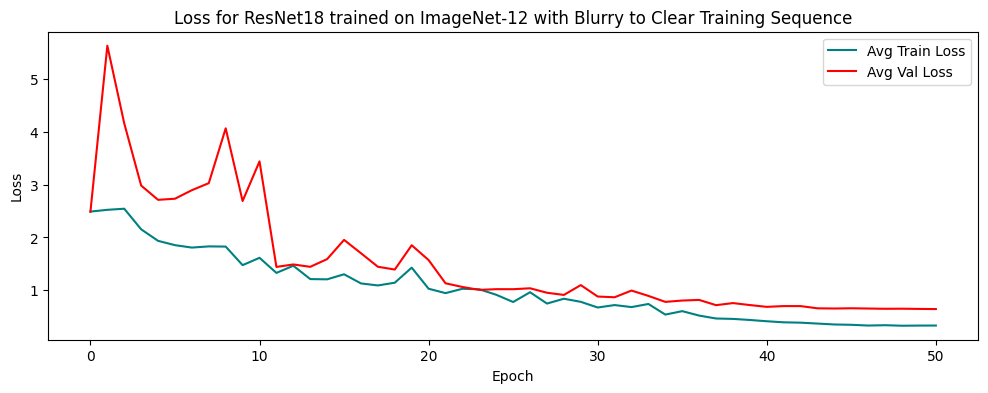

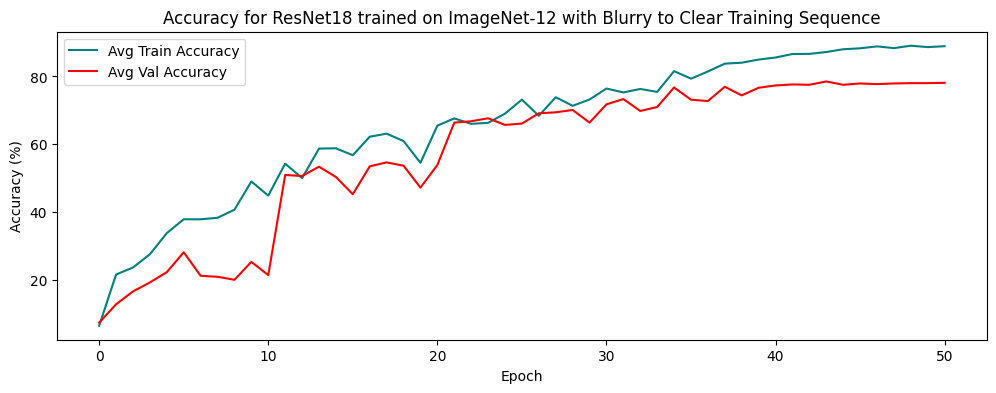

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(train_losses, color='teal', label='Avg Train Loss')
plt.plot(val_losses, color='red', label='Avg Val Loss')
plt.title(f'Loss for ResNet18 trained on ImageNet-12 with Blurry to Clear Training Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for ResNet18 trained on ImageNet-12 with Blurry to Clear Training Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()